In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder



In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping



In [81]:
features = pd.read_csv("../../0_DataPreparation/features.csv")
features

,id,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Rain,KielerWoche,CPI,...,Weather_Other,Weather_Rain,Weather_Showers_and_Thunderstorms,Weather_Snow_and_Ice,Group_brot,Group_brotchen,Group_croissant,Group_konditorei,Group_kuchen,Group_saisonbrot
0,1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,1.567431,0,93.5,...,0,0,0,0,True,False,False,False,False,False
1,1307021,2013-07-02,1,159.793757,3.0,17.3125,10.0,0.140967,0,93.5,...,1,0,0,0,True,False,False,False,False,False
2,1307031,2013-07-03,1,111.885594,7.0,21.0750,6.0,6.276774,0,93.5,...,0,1,0,0,True,False,False,False,False,False
3,1307041,2013-07-04,1,168.864941,7.0,18.8500,7.0,0.126180,0,93.5,...,0,0,0,0,True,False,False,False,False,False
4,1307051,2013-07-05,1,171.280754,5.0,19.9750,12.0,1.255988,0,93.5,...,1,0,0,0,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11159,1812226,2018-12-22,6,NaN,8.0,4.3000,4.0,0.392234,0,98.5,...,1,0,0,0,False,False,False,False,False,True
11160,1812236,2018-12-23,6,NaN,7.0,6.4500,9.0,4.244212,0,98.5,...,0,1,0,0,False,False,False,False,False,True
11161,1812246,2018-12-24,6,NaN,7.0,2.5000,10.0,0.000000,0,98.5,...,0,0,0,0,False,False,False,False,False,True
11162,1812276,2018-12-27,6,NaN,7.0,7.1250,12.0,0.000000,0,98.5,...,0,0,0,0,False,False,False,False,False,True


<Axes: >

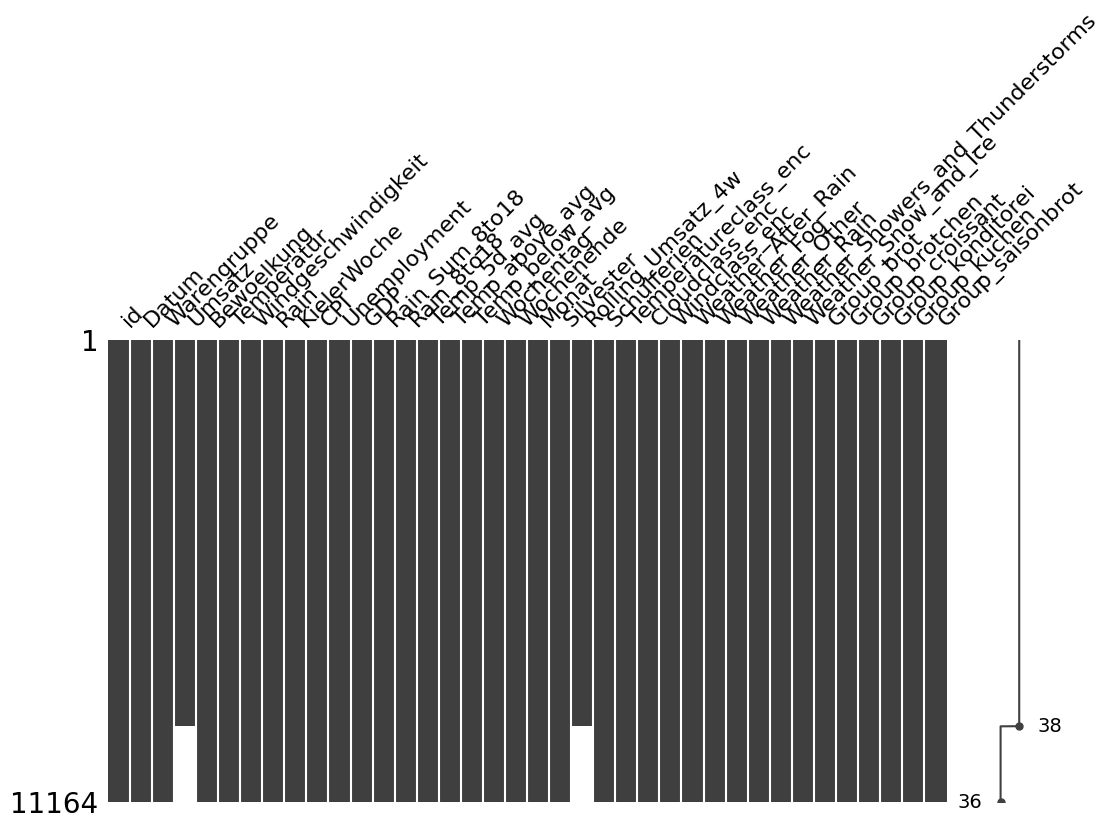

In [82]:
import missingno as msno

msno.matrix(features, figsize=(12, 6))



## Feature Selection

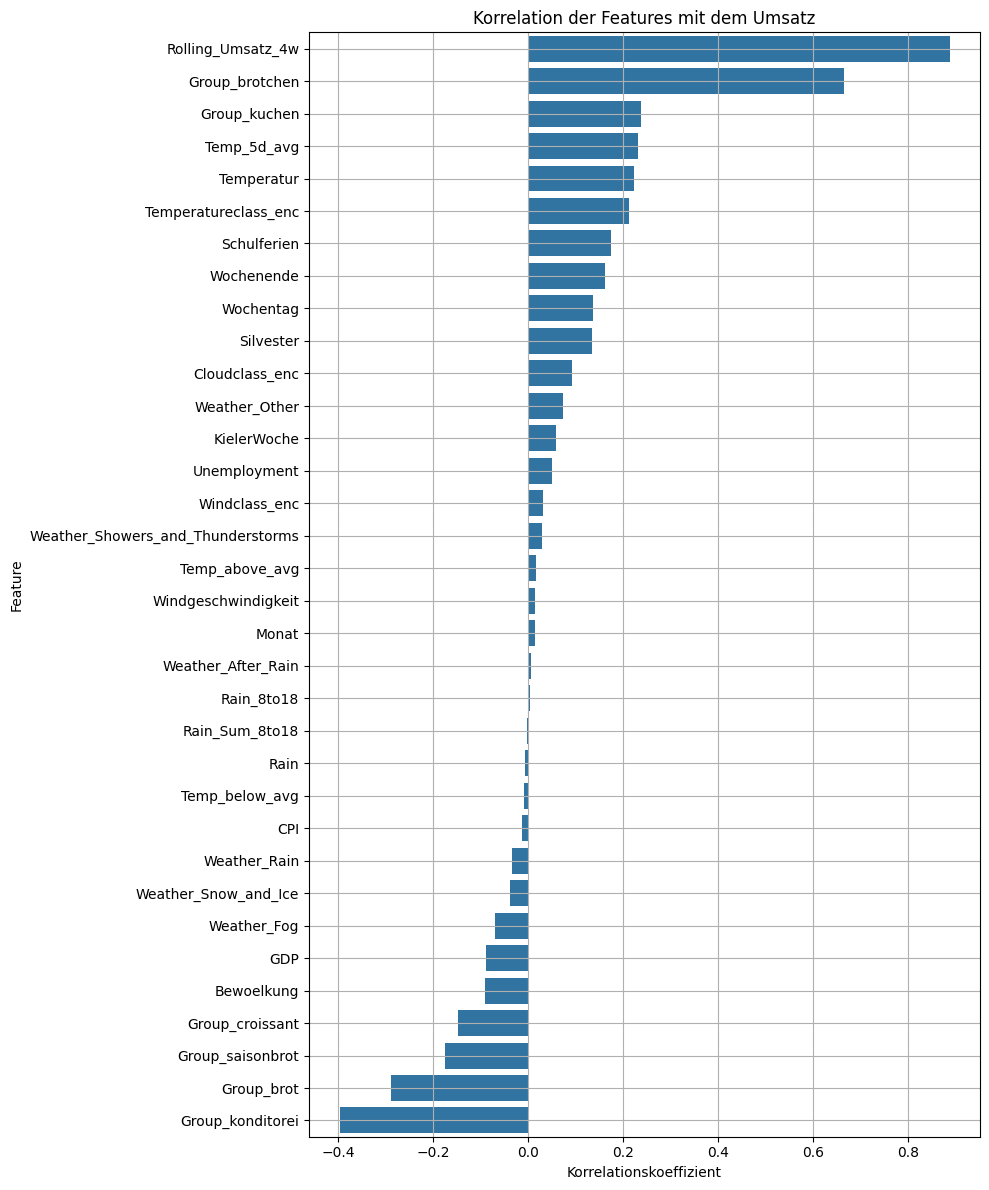

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Nur numerische Spalten betrachten (bool in float umwandeln)
numerical_features = features.drop(columns=['Datum', 'id', 'Warengruppe']).copy()
numerical_features = numerical_features.apply(lambda x: x.astype(float) if x.dtype == 'bool' else x)

# Nur Zeilen mit Umsatz (also ohne die Testdaten)
corr_data = numerical_features[features['Umsatz'].notnull()]

# Korrelation mit 'Umsatz'
correlations = corr_data.corr()['Umsatz'].drop('Umsatz').sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 12))
sns.barplot(x=correlations.values, y=correlations.index)
plt.title('Korrelation der Features mit dem Umsatz')
plt.xlabel('Korrelationskoeffizient')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
# Features mit absoluter Korrelation über 0.05
selected_features = correlations[correlations.abs() > 0.05]
selected_features = correlations
selected_feature_names = selected_features.index.tolist()

selected_feature_names.remove('Rolling_Umsatz_4w')
selected_feature_names


['Group_brotchen',
 'Group_kuchen',
 'Temp_5d_avg',
 'Temperatur',
 'Temperatureclass_enc',
 'Schulferien',
 'Wochenende',
 'Wochentag',
 'Silvester',
 'Cloudclass_enc',
 'Weather_Other',
 'KielerWoche',
 'Unemployment',
 'Windclass_enc',
 'Weather_Showers_and_Thunderstorms',
 'Temp_above_avg',
 'Windgeschwindigkeit',
 'Monat',
 'Weather_After_Rain',
 'Rain_8to18',
 'Rain_Sum_8to18',
 'Rain',
 'Temp_below_avg',
 'CPI',
 'Weather_Rain',
 'Weather_Snow_and_Ice',
 'Weather_Fog',
 'GDP',
 'Bewoelkung',
 'Group_croissant',
 'Group_saisonbrot',
 'Group_brot',
 'Group_konditorei']

In [85]:
train_end_date = '2017-07-31'
validation_end_date = '2018-07-31'


train_data = features[features['Datum']<=train_end_date].set_index("id")
vali_data = features[(features['Datum']> train_end_date) & (features['Datum']<=validation_end_date)].set_index("id")
test_data = features[(features['Datum']> validation_end_date)].set_index("id")




train_data

,Datum,Warengruppe,Umsatz,Bewoelkung,Temperatur,Windgeschwindigkeit,Rain,KielerWoche,CPI,Unemployment,...,Weather_Other,Weather_Rain,Weather_Showers_and_Thunderstorms,Weather_Snow_and_Ice,Group_brot,Group_brotchen,Group_croissant,Group_konditorei,Group_kuchen,Group_saisonbrot
id,,,,,,,,,,,,,,,,,,,,,
1307011,2013-07-01,1,148.828353,6.0,17.8375,15.0,1.567431,0,93.5,6.8,...,0,0,0,0,True,False,False,False,False,False
1307021,2013-07-02,1,159.793757,3.0,17.3125,10.0,0.140967,0,93.5,6.8,...,1,0,0,0,True,False,False,False,False,False
1307031,2013-07-03,1,111.885594,7.0,21.0750,6.0,6.276774,0,93.5,6.8,...,0,1,0,0,True,False,False,False,False,False
1307041,2013-07-04,1,168.864941,7.0,18.8500,7.0,0.126180,0,93.5,6.8,...,0,0,0,0,True,False,False,False,False,False
1307051,2013-07-05,1,171.280754,5.0,19.9750,12.0,1.255988,0,93.5,6.8,...,1,0,0,0,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1612226,2016-12-22,6,54.322960,7.0,5.2500,8.0,1.991653,0,95.6,5.8,...,0,1,0,0,False,False,False,False,False,True
1612236,2016-12-23,6,133.499200,7.0,6.3750,9.0,0.471172,0,95.6,5.8,...,0,0,0,0,False,False,False,False,False,True
1612246,2016-12-24,6,39.577538,6.0,6.1250,14.0,8.133034,0,95.6,5.8,...,0,0,1,0,False,False,False,False,False,True


In [171]:
# Separating features and labels
training_features = train_data.drop(['Umsatz','Datum'], axis=1)
validation_features = vali_data.drop(['Umsatz','Datum'], axis=1)
test_features = test_data.drop(['Umsatz','Datum'], axis=1)

training_features = train_data[selected_feature_names]
validation_features = vali_data[selected_feature_names]
test_features = test_data[selected_feature_names]

training_labels = train_data[['Umsatz']]
validation_labels = vali_data[['Umsatz']]
test_labels = test_data[['Umsatz']]


training_features = training_features.to_numpy().astype(np.float32)
training_labels = training_labels.to_numpy().astype(np.float32)

validation_features = validation_features.to_numpy().astype(np.float32)
validation_labels = validation_labels.to_numpy().astype(np.float32)

# training_labels = training_labels.values.flatten().astype(np.float32)
# validation_labels = validation_labels.values.flatten().astype(np.float32)

training_features.shape

(7493, 33)

In [172]:


tfmodel = Sequential([
  InputLayer(shape=(training_features.shape[1], )),
  BatchNormalization(),
  Dense(10, activation='relu'),
  Dense(4, activation='relu'),
  Dense(1, activation='relu')
])



tfmodel = Sequential([
    InputLayer(shape=(training_features.shape[1], )),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='relu')  # wegen Umsatz ≥ 0
])

tfmodel = Sequential([
    InputLayer(shape=(training_features.shape[1], )),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='relu'),
    Dense(1)  # No activation
])




#tfmodel = Sequential([
#  InputLayer(shape=(training_features.shape[1], )),
#  BatchNormalization(),
#  Dense(10, activation='relu'),
#  Dropout(0.2),
#  Dense(4, activation='relu'),
#  Dense(1)
#])

#tfmodel = Sequential([
#  InputLayer(shape=(training_features.shape[1], )),
#  BatchNormalization(),
#  Dense(20, activation='relu'),
#  Dropout(0.3),
#  Dense(10, activation='relu'),
#  Dense(1)
#])


tfmodel.summary()


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_52          │ (None, 33)             │           132 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 64)             │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_170 (Dense)               │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,525 (17.68 KB)

 Trainable params: 4,459 (17.42 KB)

 Non-trainable params: 66 (264.00 B)

In [173]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # was überwacht wird
    factor=0.5,           # wie stark die LR reduziert wird (hier: halbieren)
    patience=3,           # wie viele Epochen ohne Verbesserung
    min_lr=1e-6,          # kleinste erlaubte Lernrate
    verbose=1             # zeigt eine Nachricht, wenn LR reduziert wird
)

early_stop = EarlyStopping(
    monitor='val_loss',           # überwacht den Validierungsfehler
    patience=5,                   # wie viele Epochen ohne Verbesserung toleriert werden
    restore_best_weights=True,   # holt die besten Gewichte zurück
    verbose=1                     # zeigt eine Nachricht beim Stoppen
)

In [174]:
tfmodel.compile(loss="mse", optimizer=Adam(learning_rate=0.001))

history = tfmodel.fit(training_features, training_labels, epochs=50,
                      #callbacks=[reduce_lr, early_stop],
                    validation_data=(validation_features, validation_labels))

Epoch 1/50


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 63902.0508 - val_loss: 36013.1133
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22741.3750 - val_loss: 5270.5376
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7469.3965 - val_loss: 4307.3462
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7204.9575 - val_loss: 3781.1882
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6849.9448 - val_loss: 3488.0649
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7157.7397 - val_loss: 3355.9702
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6409.4624 - val_loss: 3132.0464
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6516.9639 - val_loss: 3106.9211
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6304.2871 - val_loss: 3107.1016
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5805.9805 - val_loss: 3170.5325
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5748.0601 - val_loss: 3339

In [175]:
#tfmodel = Sequential([
#  InputLayer(shape=(training_features.shape[1], )),
#  BatchNormalization(),
#  Dense(20, activation='relu'),
#  Dropout(0.3),
#  Dense(10, activation='relu'),
#  Dense(1)
#])

#model = Sequential([
#    InputLayer(shape=(training_features.shape[1], )),
#    BatchNormalization(),
#    # Dropout(0.1),
#    Dense(64, activation='relu'),
#    Dropout(0.3),
#    Dense(32, activation='relu'),
#    Dropout(0.2),
#    Dense(4, activation='relu'),
#    Dense(1)  # No activation
#])

#X_full = np.concatenate([training_features, validation_features])
#y_full = np.concatenate([training_labels, validation_labels])

#tfmodel.compile(loss="mse", optimizer=Adam(learning_rate=0.001))

#history = tfmodel.fit(X_full, y_full, epochs=100, batch_size=64,
#                      validation_split=0.1,
#                      callbacks=[reduce_lr, early_stop],
#                    )

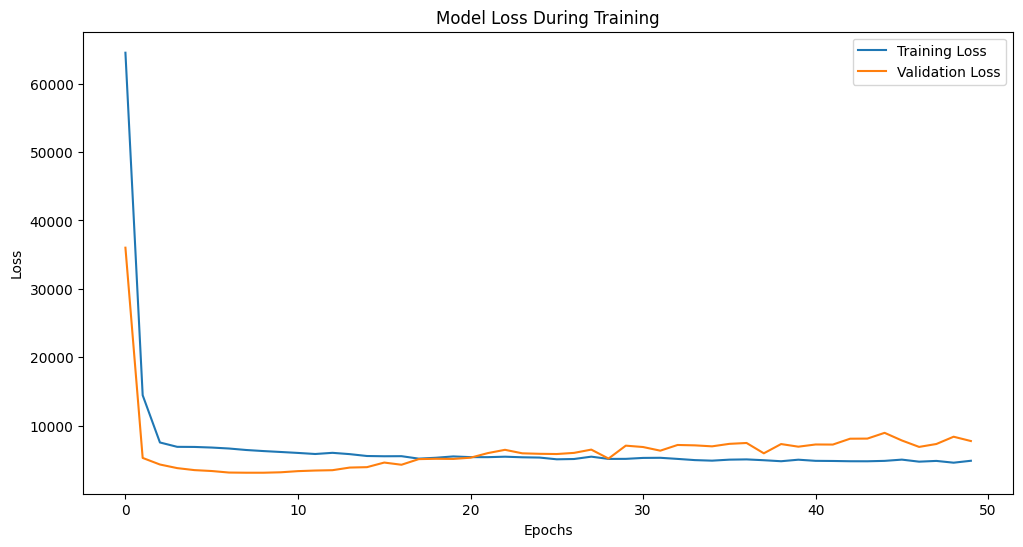

In [176]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [177]:
#for loss, val_loss in zip(history.history['loss'],history.history['val_loss']):
#    print(loss,val_loss)

In [178]:
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = tfmodel.predict(training_features)
validation_predictions = tfmodel.predict(validation_features)
test_predictions = tfmodel.predict(test_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")


235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MAPE on the Training Data: 22.48%
MAPE on the Validation Data: 25.28%


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


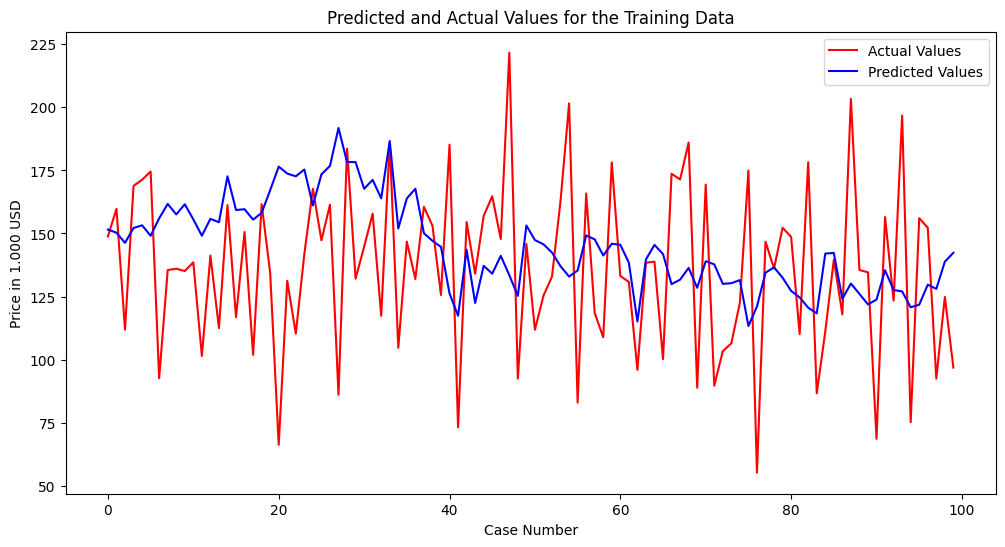

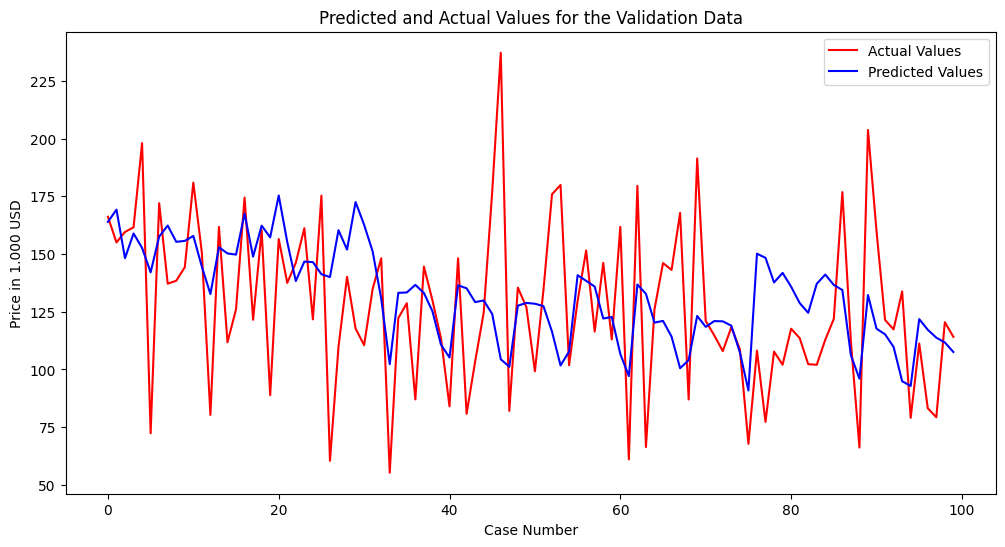

In [179]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Case Number')
    plt.ylabel('Price in 1.000 USD')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# print the type of the predictions
print(type(training_predictions))
print(type(validation_predictions))

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')

In [180]:
test_predictions = tfmodel.predict(test_features)
submission = test_data.reset_index()[['id']].copy()
submission['Umsatz'] = test_predictions.flatten()
submission.to_csv("submission.csv", index=False)

 1/58 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [104]:
test_predictions


array([[147.50198 ],
       [153.79135 ],
       [156.09305 ],
       ...,
       [ 70.73811 ],
       [ 53.828278],
       [ 49.46913 ]], dtype=float32)

In [97]:
print(test_features.shape)
print(np.isnan(test_features).sum())
print(np.min(test_features), np.max(test_features))

(1830, 33)
Group_brotchen                       0
Group_kuchen                         0
Temp_5d_avg                          0
Temperatur                           0
Temperatureclass_enc                 0
Schulferien                          0
Wochenende                           0
Wochentag                            0
Silvester                            0
Cloudclass_enc                       0
Weather_Other                        0
KielerWoche                          0
Unemployment                         0
Windclass_enc                        0
Weather_Showers_and_Thunderstorms    0
Temp_above_avg                       0
Windgeschwindigkeit                  0
Monat                                0
Weather_After_Rain                   0
Rain_8to18                           0
Rain_Sum_8to18                       0
Rain                                 0
Temp_below_avg                       0
CPI                                  0
Weather_Rain                         0
Weather_Snow_a